<a href="https://colab.research.google.com/github/Datkhoo25/Multilevel-Dynamic-Relation-Graph-Attention-Network-DR-GAT-/blob/main/Base_Model_3_(With_Residual)_GRU_w_Fixed_GAT_%2B_HP(WS10)__(IRR_MRR20).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf

!pip uninstall -y kerastuner
!pip install keras-tuner
import numpy as np
import keras_tuner as kt
from tqdm import tqdm
import matplotlib.pyplot as plt
!pip install numba
from numba import cuda
import time

import os
import random
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_random_seeds()
# Ensure deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
# Though with all this step, tere are still controlled noise which actually can help with robustness of the model.
# https://github.com/NVIDIA/framework-reproducibility/blob/master/doc/d9m/README.md
# https://github.com/NVIDIA/framework-reproducibility/blob/master/doc/d9m/tensorflow.md

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.0 MB/s eta 0:00:00


In [ ]:
file_path_train = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_train_complete.pkl'
with open(file_path_train, 'rb') as file:
    train_data = pickle.load(file)
print(f"Data has been loaded from {file_path_train}")

file_path_val = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_val_complete.pkl'
with open(file_path_val, 'rb') as file:
    val_data = pickle.load(file)
print(f"Data has been loaded from {file_path_val}")

file_path_test = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_test_complete.pkl'
with open(file_path_test, 'rb') as file:
    test_data = pickle.load(file)
print(f"Data has been loaded from {file_path_test}")

Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_train_complete.pkl
Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_val_complete.pkl
Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_test_complete.pkl


In [ ]:
x_train = train_data[0][:, :, :, :2]
y_train = train_data[1][:]
print(x_train.shape, y_train.shape)

x_val = val_data[0][:, :, :, :2]
y_val = val_data[1][:]
print(x_val.shape, y_val.shape)

x_test = test_data[0][:, :, :, :2]
y_test = test_data[1][:]
print(x_test.shape, y_test.shape)

# Ensure data types are compatible with TensorFlow
x_train = tf.cast(x_train, dtype=tf.float32)
y_train = tf.cast(y_train, dtype=tf.float32)
x_val = tf.cast(x_val, dtype=tf.float32)
y_val = tf.cast(y_val, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)

(74, 551, 20, 2) (74, 551)
(24, 551, 20, 2) (24, 551)
(24, 551, 20, 2) (24, 551)


Loading Fixed Adj Matrices

In [ ]:
file_path_f_adj_matrix = f'/content/drive/MyDrive/Colab Notebooks/GNN/combined_adj_matrix.pkl'
with open(file_path_f_adj_matrix, 'rb') as file:
    f_adj_matrix = pickle.load(file)

print(f_adj_matrix.keys())
print(f_adj_matrix['total_list_of_property'])
relation_list = f_adj_matrix['total_list_of_property']

relation_list_w = relation_list[0:-1]
adj_matrices_wiki = []
for i in relation_list[0:-1]:
  print("The relation is", i, "in np array form")
  # print(f_adj_matrix['adj_matrices'][i])
  adj_matrices_wiki.append(f_adj_matrix['adj_matrices'][i])


print("The relation is", relation_list[-1])
relation_list_i = [relation_list[-1]]
adj_matrices_industry = [f_adj_matrix['adj_matrices'][relation_list[-1]]]

dict_keys(['lookup_dict', 'total_list_of_property', 'adj_matrices'])
['followsTicker', 'subsidiaryTicker', 'parentTicker', 'ownedByTicker', 'ownerOfTicker', 'industryLabel', 'legalformLabel', 'founded_byLabel', 'prod_mat_producedLabel', 'complies_withLabel', 'GISC_industry']
The relation is followsTicker in np array form
The relation is subsidiaryTicker in np array form
The relation is parentTicker in np array form
The relation is ownedByTicker in np array form
The relation is ownerOfTicker in np array form
The relation is industryLabel in np array form
The relation is legalformLabel in np array form
The relation is founded_byLabel in np array form
The relation is prod_mat_producedLabel in np array form
The relation is complies_withLabel in np array form
The relation is GISC_industry


In [ ]:
def compute_irr_top20(predictions, ground_truth, sample_weight=None):
    top20_indices = tf.math.top_k(predictions, k=20).indices
    top20_returns = tf.gather(ground_truth, top20_indices, batch_dims=1)
    irr = tf.reduce_mean(top20_returns)
    return irr

def pointwise_regression_loss(predictions, targets, sample_weight=None):
    point_wise_loss = tf.reduce_mean(tf.square(predictions - targets), axis=1)
    total_loss = tf.reduce_sum(point_wise_loss)
    return total_loss

def compute_mrr_top20(predictions, ground_truth, sample_weight=None):
    top20 = tf.math.top_k(predictions, k=20)
    top20_indices = top20.indices
    top20_ground_truth = tf.gather(ground_truth, top20_indices, batch_dims=1)
    relevance_mask = tf.cast(top20_ground_truth > 0, tf.float32)  # Shape: [batch_size, 10]
    positions = tf.range(1, 21, dtype=tf.float32)
    positions = tf.reshape(positions, (1, -1))
    modified_positions = tf.where(relevance_mask > 0, positions, tf.fill(tf.shape(positions), 21.0))
    first_relevant_position = tf.reduce_min(modified_positions, axis=1)  # Shape: [batch_size]
    reciprocal_rank = tf.where(first_relevant_position <= 20, 1.0 / first_relevant_position, 0.0)
    overall_mrr = tf.reduce_mean(reciprocal_rank)
    return overall_mrr

Using deteministic

Initial Using Fully Dense Matrix for Attention -Working FIne but the tuner and rerun result are not consistent.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU, Dense
from tensorflow.keras.regularizers import l2
import kerastuner as kt
import gc
import random
import os

tf.config.run_functions_eagerly(False)


# Set GPU memory limit and enable memory growth
def set_gpu_memory_limit(memory_limit):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Enable memory growth
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Set memory limit
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=memory_limit)]
            )
            print(f"Set GPU memory limit to {memory_limit} MB")
        except RuntimeError as e:
            print(e)

# Define the GAT model and other necessary classes/functions
class MultiHeadGATLayer(tf.keras.layers.Layer):
    def __init__(self, gru_units, num_heads, head_dim, adj_matrices):
        super(MultiHeadGATLayer, self).__init__()
        self.gru_units = gru_units
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.num_relations = len(adj_matrices)
        self.adj_matrices = [tf.cast(adj, dtype=tf.float32) for adj in adj_matrices]
        self.gat_output_shape = None

        self.W1 = [
            [self.add_weight(
                shape=(gru_units, self.head_dim),
                initializer=tf.keras.initializers.RandomNormal(seed=42),  # Seeded initializer
                trainable=True,
                name=f"W1_rel{r}_head{h}"
            ) for h in range(num_heads)]
            for r in range(self.num_relations)
        ]

        self.r = [
            [self.add_weight(
                shape=(2 * self.head_dim, 1),
                initializer=tf.keras.initializers.RandomNormal(seed=42),  # Seeded initializer
                trainable=True,
                name=f"r_rel{r}_head{h}"
            ) for h in range(self.num_heads)]
            for r in range(self.num_relations)
        ]

        self.leaky_relu = LeakyReLU(negative_slope=0.2)

    def build(self, input_shape):
        self.num_stocks = input_shape[1]
        super(MultiHeadGATLayer, self).build(input_shape)

    def call(self, inputs):
        head_outputs = []
        batch_size = tf.shape(inputs)[0]

        for r in range(self.num_relations):
            relation_head_outputs = []
            for h in range(self.num_heads):
                W1_rh = self.W1[r][h]
                r_rh = self.r[r][h]

                h_i = tf.matmul(inputs, W1_rh)
                h_j = tf.expand_dims(h_i, axis=2)
                h_j = tf.tile(h_j, [1, 1, self.num_stocks, 1])
                h_i_expanded = tf.expand_dims(h_i, axis=1)
                h_i_expanded = tf.tile(h_i_expanded, [1, self.num_stocks, 1, 1])
                concat_features = tf.concat([h_i_expanded, h_j], axis=-1)
                concat_features_reshaped = tf.reshape(concat_features, [-1, 2 * self.head_dim])

                scores = self.leaky_relu(tf.matmul(concat_features_reshaped, r_rh))
                scores = tf.reshape(scores, [batch_size, self.num_stocks, self.num_stocks])

                adj_matrix = tf.expand_dims(self.adj_matrices[r], axis=0)
                adj_matrix = tf.tile(adj_matrix, [batch_size, 1, 1])
                masked_scores = tf.where(adj_matrix > 0, scores, -1e9 * tf.ones_like(scores))
                attention_weights = tf.nn.softmax(masked_scores, axis=-1)
                output = tf.matmul(attention_weights, h_i)
                relation_head_outputs.append(output)

            relation_output = tf.concat(relation_head_outputs, axis=-1)
            head_outputs.append(relation_output)

        final_output = tf.reduce_mean(tf.stack(head_outputs, axis=-1), axis=-1)
        self.gat_output_shape = final_output.shape
        return tf.nn.relu(final_output)

    def compute_output_shape(self, input_shape):
        return self.gat_output_shape

class MultiStockGRUModel(tf.keras.Model):
    def __init__(self, gru_units, dense_units, dense_units2, num_heads, head_dim,
                 adj_matrices_w, adj_matrices_i, number_of_layers, dense_initializer, dense_activation, l2_lambda=0.005):
        super(MultiStockGRUModel, self).__init__()
        self.gru_units = gru_units
        self.num_dense_layers = number_of_layers
        self.l2_lambda = l2_lambda
        self.gru_layers = []
        self.dense_units = dense_units
        self.dense_units2 = dense_units2

        # Build the dense layers stack with kernel_regularizer added
        self.dense_layers = []

        for _ in range(number_of_layers - 1):
            if dense_activation == 'leaky_relu':
                self.dense_layers.append(
                    tf.keras.Sequential([
                        Dense(dense_units, activation=None, kernel_initializer=dense_initializer,
                              kernel_regularizer=l2(l2_lambda)),
                        LeakyReLU(negative_slope =0.2)
                    ])
                )
            else:
                self.dense_layers.append(
                    Dense(dense_units, activation=dense_activation, kernel_initializer=dense_initializer,
                          kernel_regularizer=l2(l2_lambda))
                )
        # Final dense layer (unchanged, but you can also add regularization if desired)
        self.dense_layers.append(
            Dense(dense_units2, activation=None, kernel_regularizer=l2(l2_lambda))
        )

        # Initialize your custom GAT layers as before
        self.gat_layer_w = MultiHeadGATLayer(gru_units, num_heads, head_dim, adj_matrices_w)
        self.gat_layer_i = MultiHeadGATLayer(gru_units, num_heads, head_dim, adj_matrices_i)

    def build(self, input_shape):
        self.num_stocks = input_shape[1]
        self.gru_layers = [
            tf.keras.layers.GRU(self.gru_units, return_sequences=False, name=f"GRU_Stock_{i}")
            for i in range(self.num_stocks)
        ]

    def call(self, inputs, adj_matrices=None):
        batch_size = tf.shape(inputs)[0]

        stock_outputs = []
        for i in range(self.num_stocks):
            stock_input = inputs[:, i, :, :]
            stock_output = self.gru_layers[i](stock_input)
            stock_outputs.append(stock_output)

        fused_output = tf.stack(stock_outputs, axis=1)

        gat_output_w = self.gat_layer_w(fused_output)

        gat_output_i = self.gat_layer_i(fused_output)

        gat_combined = tf.concat([gat_output_w, gat_output_i], axis=-1)

        x = gat_combined
        x = self.dense_layers[0](x)
        x = tf.concat([x, fused_output], axis=-1)  # Concatenating residual connection after one dense layer

        for i in range(1, len(self.dense_layers)):
            x = self.dense_layers[i](x)

        final_output = tf.squeeze(x, axis=-1)

        return final_output



class CustomMetric(tf.keras.metrics.Metric):
    def __init__(self, metric_fn, name, **kwargs):
        super(CustomMetric, self).__init__(name=name, **kwargs)
        self.metric_fn = metric_fn
        self.result_value = self.add_weight(name=f"{name}_value", initializer="zeros")
        self.count = self.add_weight(name=f"{name}_count", initializer="zeros")

    @tf.function
    def update_state(self, y_true, y_pred, **kwargs):
        value = self.metric_fn(y_pred, y_true, **kwargs)
        self.result_value.assign_add(value)
        self.count.assign_add(1.0)

    @tf.function
    def result(self):
        return self.result_value / tf.maximum(self.count, 1.0)

    @tf.function
    def reset_states(self):
        self.result_value.assign(0.0)
        self.count.assign(0.0)

metrics = [
    CustomMetric(pointwise_regression_loss, name="pointwise_regression_loss"),
    CustomMetric(compute_irr_top20, name="compute_irr_top20"),
    CustomMetric(compute_mrr_top20, name="compute_mrr_top20")
]

@tf.function
def optimized_custom_loss_function(y_true, y_pred, model=None, alpha=1.0, lambda_=0.01):
    pointwise_loss = tf.reduce_mean(tf.square(y_pred - y_true))
    batch_size = tf.shape(y_true)[0]
    y_pred_diff = tf.expand_dims(y_pred, 2) - tf.expand_dims(y_pred, 1)
    y_true_diff = tf.expand_dims(y_true, 2) - tf.expand_dims(y_true, 1)
    pairwise_loss = tf.reduce_sum(tf.maximum(0.0, -y_pred_diff * y_true_diff))
    pairwise_loss = alpha * pairwise_loss / tf.cast(batch_size, tf.float32)
    l2_loss = 0.0
    if model is not None:
        l2_loss = lambda_ * tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
    loss = pointwise_loss + pairwise_loss + l2_loss
    return loss



class CustomHyperModel(kt.HyperModel):
    def build(self, hp):
        gru_units = hp.Choice('gru_units', [24, 36, 48])
        dense_units = hp.Choice('dense_units', [24, 36, 48])
        head_dim = hp.Choice('head_dim', [7, 10])
        num_heads = hp.Choice('num_heads', [8, 10])
        dense_units2 = 1
        number_of_layers = hp.Choice('number_of_layers', [2, 3, 4])
        dense_initializer = hp.Choice("dense_initializer", ['glorot_uniform', 'he_normal', 'lecun_normal', 'random_normal'])
        dense_activation = hp.Choice("dense_activation", ['linear', 'relu', 'leaky_relu', 'softmax'])
        alpha = hp.Choice('alpha', [2.0, 1.5, 1.0])
        lambda_ = hp.Choice('lambda', [0.05, 0.005])

        # Initialize model with adjacency matrices (assumed to be defined)
        model = MultiStockGRUModel(
            gru_units, dense_units, dense_units2, num_heads, head_dim,
            adj_matrices_wiki, adj_matrices_industry,
            number_of_layers, dense_initializer, dense_activation, l2_lambda=0.005
        )
        model.build((None, x_train.shape[1], x_train.shape[2], x_train.shape[3]))

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer,
                      loss=lambda y_true, y_pred: optimized_custom_loss_function(y_true, y_pred, model, alpha=alpha, lambda_=lambda_),
                      metrics=metrics)
        return model

    @tf.function
    def run_trial(self, trial, x_train, y_train, x_val, y_val, epochs, batch_size, **kwargs):
        try:
            # Build and compile the model
            model = self.build(trial.hyperparameters)
            # Define early stopping callback
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',  # Metric to monitor
                patience=1,          # Number of epochs with no improvement after which training will be stopped
                restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
            )
            # Fit the model with early stopping
            history = model.fit(
                x_train, y_train,
                validation_data=(x_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping],  # Add early stopping callback
                **kwargs
            )
        finally:
            # Ensure CUDA device is reset after each trial
            tf.keras.backend.clear_session()
            gc.collect()
        return history

# Set GPU memory limit to 14.5 GB (14500 MB) and enable memory growth
set_gpu_memory_limit(14800)

tuner = kt.RandomSearch(
    CustomHyperModel(),
    objective=kt.Objective('val_compute_irr_top20', direction='max'),
    max_trials=140,
    executions_per_trial=2,# Run 2 trials to leverage the non-deterministic nature of validation dataset as a proxy for a better result for test dataset.
    directory='/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 3: GAT with fixed graph and GRU/',
    project_name=f'BSM3_HP_(Wiki n Industry)_GPU_Mem_lim_w_growth_1(Res_Val_IRR)')

# Start hyperparameter search (adjacency matrices are passed during model building)
tuner.search(
    x_train,
    y_train,
    epochs=6,
    validation_data=(x_val, y_val),
    verbose=1,  # Ensure verbose is set to 1 to print epoch status
    batch_size=2)


class CustomModel(tf.keras.Model):
    def __init__(self, loaded_model):
        super(CustomModel, self).__init__()
        self.loaded_model = loaded_model

    def call(self, inputs):
        return self.loaded_model.signatures['serving_default'](inputs)['output_0']

Physical devices cannot be modified after being initialized


<ipython-input-6-47475930f1f8>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/GNN/Baseline 3: GAT with fixed graph and GRU/BSM3_HP_(Wiki n Industry)_GPU_Mem_lim_w_growth_1(Res_Val_IRR)/tuner0.json


In [ ]:
# Extract best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrain the model with the best hyperparameters
set_random_seeds()  # Ensure reproducibility


model = CustomHyperModel().build(best_hps)

# Start counting time
start_time = time.time()

history = model.fit(
   x_train, y_train,
   validation_data=(x_val, y_val),
   epochs=6,
   batch_size=2,
   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)]
)

# Stop counting time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Training Time: {elapsed_time:.2f} seconds")

save_path = '/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 3: GAT with fixed graph and GRU/saved_model1'

Epoch 1/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - compute_irr_top20: 0.0039 - compute_mrr_top20: 0.7535 - loss: 4849.3940 - pointwise_regression_loss: 0.2037 - val_compute_irr_top20: 1.6778e-04 - val_compute_mrr_top20: 0.5431 - val_loss: 1055.7440 - val_pointwise_regression_loss: 0.0253
Epoch 2/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - compute_irr_top20: 0.0041 - compute_mrr_top20: 0.6801 - loss: 840.0454 - pointwise_regression_loss: 0.0135 - val_compute_irr_top20: 7.2054e-04 - val_compute_mrr_top20: 0.6917 - val_loss: 403.8551 - val_pointwise_regression_loss: 0.0031
Epoch 3/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - compute_irr_top20: 0.0079 - compute_mrr_top20: 0.6961 - loss: 356.8484 - pointwise_regression_loss: 0.0030 - val_compute_irr_top20: 2.2434e-04 - val_compute_mrr_top20: 0.5931 - val_loss: 286.3369 - val_pointwise_regression_loss: 0.0023
Epoch 4/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - compute_irr_top20: 0.0081 - compute_mrr_top20: 0.7279 - loss: 256.2319 - pointwise_re

In [ ]:
# Save the model in TensorFlow SavedModel format
tf.saved_model.save(model, save_path)

tf.keras.backend.clear_session()
gc.collect()

# Load the model with custom objects
loaded_model = tf.saved_model.load(save_path)

custom_model = CustomModel(loaded_model)
custom_model.compile(optimizer='adam', loss=optimized_custom_loss_function, metrics=metrics)

# Assuming x_test and y_test are defined
test_results = custom_model.evaluate(x_test, y_test, batch_size=2)
print(f"Test Results: {test_results}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 382ms/step - compute_irr_top20: 0.0045 - compute_mrr_top20: 0.6737 - loss: 49.8712 - pointwise_regression_loss: 0.0020
Test Results: [54.777042388916016, 0.002104878192767501, 0.0061933803372085094, 0.6940972208976746]


Best Hyperparameter Combination:
GRU Units: 24
Dense Units: 36
Head Dim: 10
Num Heads: 8
Number of Layers: 2
Dense Initializer: random_normal
Dense Activation: leaky_relu
Alpha: 2.0
Lambda: 0.05


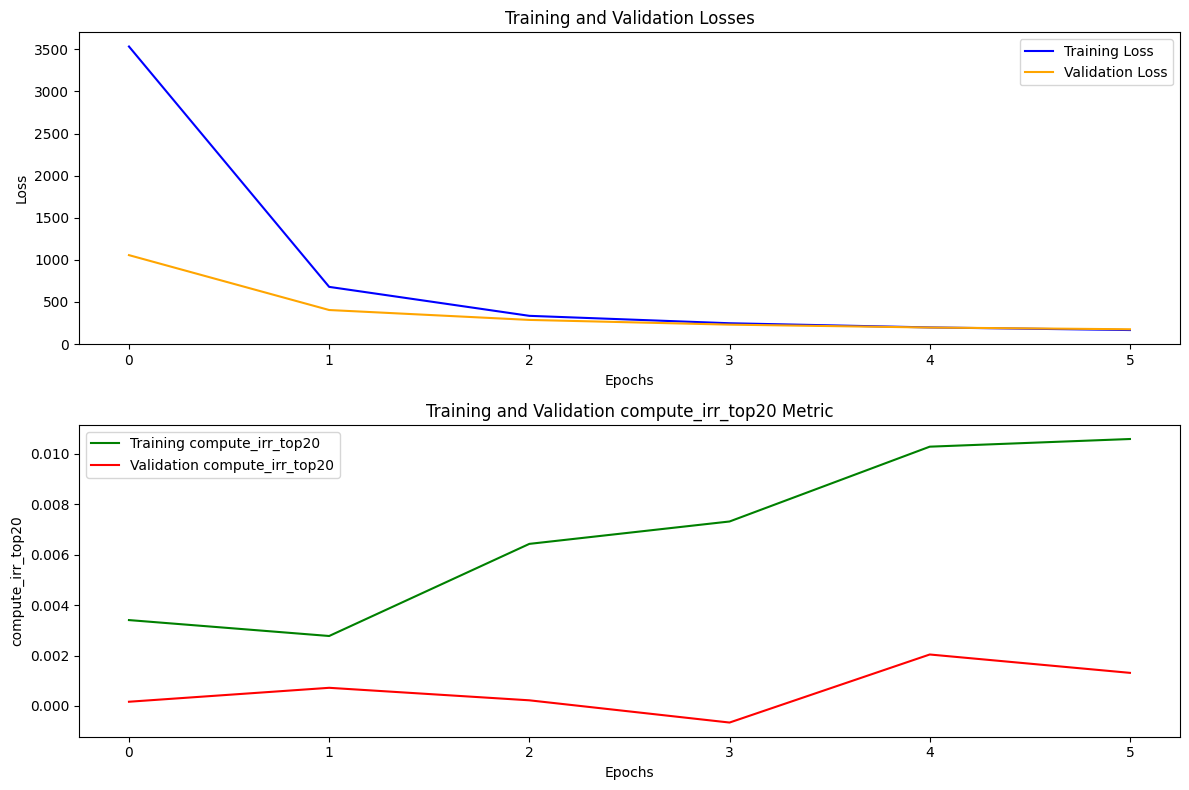

In [ ]:
# Print the best hyperparameter combination (for your reference)
print("Best Hyperparameter Combination:")
print(f"GRU Units: {best_hps.get('gru_units')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Head Dim: {best_hps.get('head_dim')}")
print(f"Num Heads: {best_hps.get('num_heads')}")
print(f"Number of Layers: {best_hps.get('number_of_layers')}")
print(f"Dense Initializer: {best_hps.get('dense_initializer')}")
print(f"Dense Activation: {best_hps.get('dense_activation')}")
print(f"Alpha: {best_hps.get('alpha')}")
print(f"Lambda: {best_hps.get('lambda')}")


train_loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
train_pointwise_regression_loss = history.history.get('pointwise_regression_loss', [])
val_pointwise_regression_loss = history.history.get('val_pointwise_regression_loss', [])
train_compute_irr_top20 = history.history.get('compute_irr_top20', [])
val_compute_irr_top20 = history.history.get('val_compute_irr_top20', [])
train_compute_mrr_top20 = history.history.get('compute_mrr_top20', [])
val_compute_mrr_top20 = history.history.get('val_compute_mrr_top20', [])

# Save the results to a dictionary
results = {
   'best_hyperparameters': {
       'gru_units': best_hps.get('gru_units'),
       'dense_units': best_hps.get('dense_units'),
       'head_dim': best_hps.get('head_dim'),
       'num_heads': best_hps.get('num_heads'),
       'number_of_layers': best_hps.get('number_of_layers'),
       'dense_initializer': best_hps.get('dense_initializer'),
       'dense_activation': best_hps.get('dense_activation'),
       'alpha': best_hps.get('alpha'),
       'lambda': best_hps.get('lambda')
   },
   'train_loss': train_loss,
   'val_loss': val_loss,
   'train_metrics': {
       'pointwise_regression_loss': train_pointwise_regression_loss,
       'compute_irr_top20': train_compute_irr_top20,
       'compute_mrr_top20': train_compute_mrr_top20
   },
   'val_metrics': {
       'val_pointwise_regression_loss': val_pointwise_regression_loss,
       'val_compute_irr_top20': val_compute_irr_top20,
       'val_compute_mrr_top20': val_compute_mrr_top20
   },
   'test_metrics': {
       'pointwise_regression_loss': test_results[1],
       'compute_irr_top20': test_results[2],
       'compute_mrr_top20': test_results[3]
   },
   'training_time': elapsed_time
}

# Save the dictionary to a pickle file with a name based on the tuner project name
pickle_filename = f"/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 3: GAT with fixed graph and GRU/BSM3_HP_(Wiki n Industry)_1.pkl"
with open(pickle_filename, "wb") as f:
   pickle.dump(results, f)

# Plot the training and validation losses and compute_irr_top20 metric
plt.figure(figsize=(12, 8))

# Subplot for Loss
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Subplot for compute_irr_top20
plt.subplot(2, 1, 2)
plt.plot(train_compute_irr_top20, label='Training compute_irr_top20', color='green')
plt.plot(val_compute_irr_top20, label='Validation compute_irr_top20', color='red')
plt.xlabel('Epochs')
plt.ylabel('compute_irr_top20')
plt.title('Training and Validation compute_irr_top20 Metric')
plt.legend()

plt.tight_layout()
plt.show()